# DA Price Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor

from mapie.regression import MapieTimeSeriesRegressor
from mapie.conformity_scores import GammaConformityScore
from mapie.subsample import BlockBootstrap
from mapie.metrics import regression_mean_width_score, regression_coverage_score

import warnings
import xml.etree.ElementTree as ET
from datetime import timedelta
import os
import pickle

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

In [2]:
random_state = 77

In [3]:
modelFolder = "Models"
if not os.path.exists(modelFolder):
    os.makedirs(modelFolder)

In [4]:
evalFolder = "EnergyHubEval"
if not os.path.exists(evalFolder):
    os.makedirs(evalFolder)

In [5]:
# source: https://ember-energy.org/data/european-wholesale-electricity-price-data/
# source: https://transparency.entsoe.eu

## Data Exploration

### load and generation

In [ ]:
def read_entsoe_load_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Define namespace mapping (the XML file uses a default namespace)
    ns = {'ns': 'urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0'}

    records = []

    for ts in root.findall('ns:TimeSeries', ns):
        period = ts.find('ns:Period', ns)
        if period is None:
            continue
        time_interval = period.find('ns:timeInterval', ns)
        if time_interval is None:
            continue
        start_text = time_interval.find('ns:start', ns).text
        start_dt = pd.to_datetime(start_text, utc=True)
        
        for point in period.findall('ns:Point', ns):
            pos_node = point.find('ns:position', ns)
            qty_node = point.find('ns:quantity', ns)
            if pos_node is None or qty_node is None:
                continue
            pos = int(pos_node.text)
            power = float(qty_node.text)
            dt = start_dt + timedelta(minutes=15 * (pos - 1))
            records.append({'datetime': dt, 'power': power})

    file_df = pd.DataFrame(records)
    file_df = file_df.sort_values("datetime").reset_index(drop=True)

    return file_df

In [ ]:
def read_entsoe_resgen_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    ns = {'ns': 'urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0'}

    records = []
    for ts in root.findall('ns:TimeSeries', ns):
        psr_elem = ts.find('ns:MktPSRType/ns:psrType', ns)
        if psr_elem is None:
            continue
        psr = psr_elem.text 

        period = ts.find('ns:Period', ns)
        if period is None:
            continue
        time_interval = period.find('ns:timeInterval', ns)
        if time_interval is None:
            continue

        start_text = time_interval.find('ns:start', ns).text
        start_dt = pd.to_datetime(start_text, utc=True)

        for point in period.findall('ns:Point', ns):
            pos_node = point.find('ns:position', ns)
            qty_node = point.find('ns:quantity', ns)
            if pos_node is None or qty_node is None:
                continue
            pos = int(pos_node.text)
            quantity = float(qty_node.text)
            dt = start_dt + timedelta(minutes=15 * (pos - 1))
            records.append({'datetime': dt, 'power': quantity, 'psrType': psr})

    df = pd.DataFrame(records)
    df = df.sort_values("datetime").reset_index(drop=True)
    df_pivot = df.pivot(index='datetime', columns='psrType', values='power')
    df_pivot.index.name = None
    df_pivot.columns.name = None

    return df_pivot


In [8]:
files_load = [f for f in os.listdir('Data/Grid_NL') if 'DAY_AHEAD_TOTAL_LOAD_FORECAST' in f]
load = pd.concat([read_entsoe_load_xml(os.path.join('Data/Grid_NL', load_i)) for load_i in files_load], ignore_index=True)

files_resgen = [f for f in os.listdir('Data/Grid_NL') if 'DAY_AHEAD_GENERATION_FORECAST_WIND_SOLAR' in f]
resgen = pd.concat([read_entsoe_resgen_xml(os.path.join('Data/Grid_NL', resgen_i)) for resgen_i in files_resgen], ignore_index=False)

In [9]:
load.sort_values('datetime', inplace=True)
load.reset_index(drop=True, inplace=True)
load.drop_duplicates('datetime', inplace=True)

resgen['datetime'] = resgen.index
resgen.sort_values('datetime', inplace=True)
resgen.reset_index(drop=True, inplace=True)
resgen.drop_duplicates('datetime', inplace=True)

load.fillna(0, inplace=True)
resgen.fillna(0, inplace=True)

In [10]:
load_hourly = load.set_index('datetime').resample('h').mean()
resgen_hourly = resgen.set_index('datetime').resample('h').mean()

load_hourly.fillna(0, inplace=True)
resgen_hourly.fillna(0, inplace=True)

In [11]:
resgen_hourly['respower'] = resgen_hourly['B16'] + resgen_hourly['B18'] + resgen_hourly['B19']
resgen_hourly.drop(columns=['B16', 'B18', 'B19'], inplace=True)

In [12]:
load_gen = load_hourly.merge(resgen_hourly, left_index=True, right_index=True, how='inner')
load_gen['resload'] = load_gen['power'] - load_gen['respower']

<Axes: xlabel='datetime'>

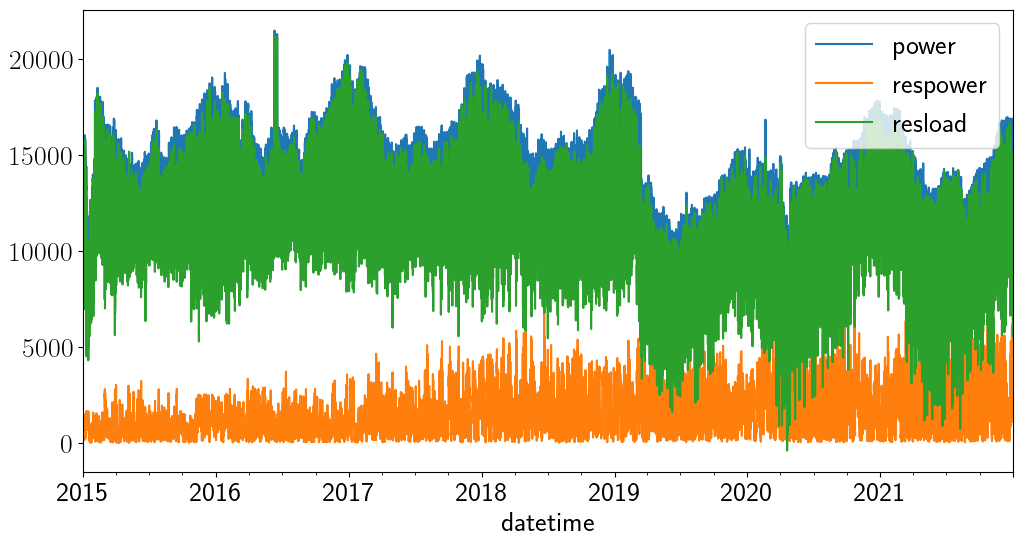

In [13]:
# load.loc[(load['datetime'].dt.year==2016) & (load['datetime'].dt.month == 6)].plot(x='datetime', y='power', figsize=(12, 6))
load_gen.plot(y=['power', 'respower', 'resload'], figsize=(12, 6))

<Axes: xlabel='datetime'>

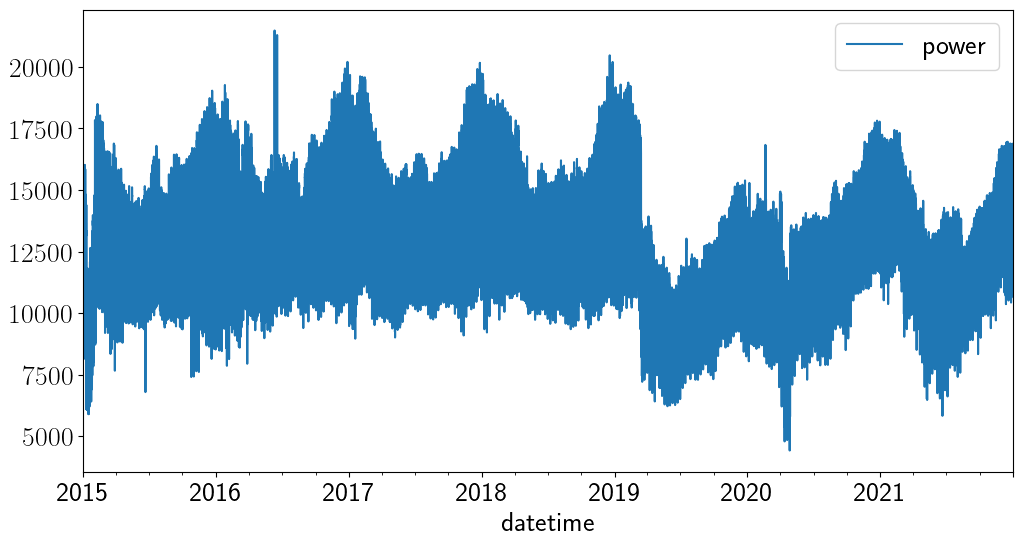

In [14]:
load_hourly.reset_index().plot(x='datetime', y='power', figsize=(12, 6))

In [15]:
load_gen = load_gen.reset_index()

In [16]:
load_gen['datetime'] = load_gen['datetime'].dt.tz_convert('Europe/Amsterdam')

In [17]:
load_gen.head()

,datetime,power,respower,resload
0,2015-01-01 01:00:00+01:00,9011.50,420.50,8591.00
1,2015-01-01 02:00:00+01:00,8607.75,449.75,8158.00
2,2015-01-01 03:00:00+01:00,8461.75,479.50,7982.25
3,2015-01-01 04:00:00+01:00,8499.50,509.75,7989.75
4,2015-01-01 05:00:00+01:00,8880.00,539.50,8340.50


### prices

In [18]:
price = pd.read_csv('Data/Grid_NL/DA_prices_NL.csv')

In [19]:
price.columns

Index(['Country', 'ISO3 Code', 'Datetime (UTC)', 'Datetime (Local)',
       'Price (EUR/MWhe)'],
      dtype='object')

In [20]:
price['datetime'] = pd.to_datetime(price['Datetime (UTC)'], utc=True).dt.tz_convert('Europe/Amsterdam')
priceClean = price.loc[:, ['datetime', 'Price (EUR/MWhe)']].copy()
priceClean.columns = ['datetime', 'price']
priceClean['pricekWh'] = priceClean['price'] / 1000

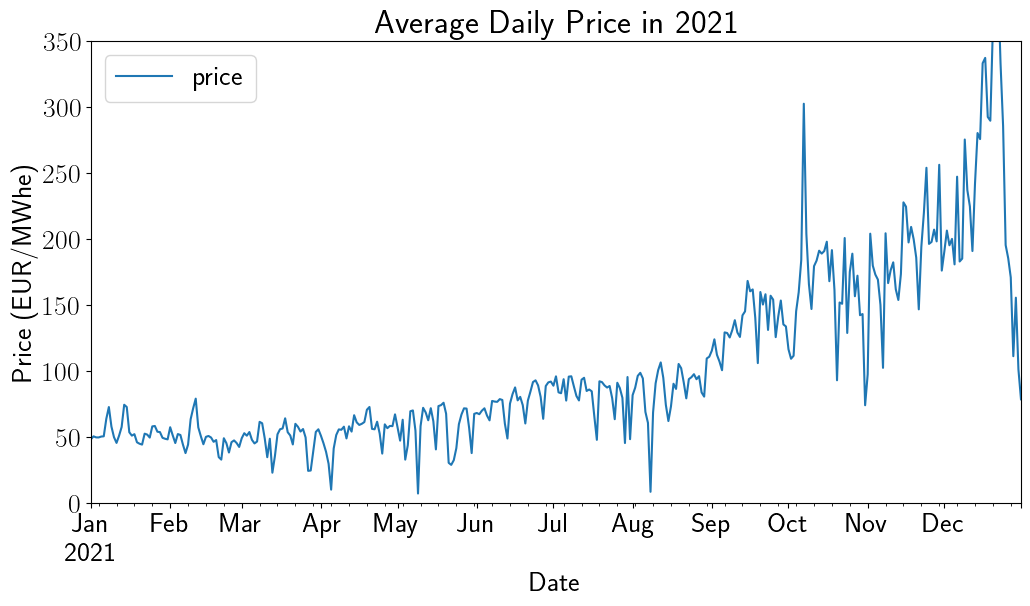

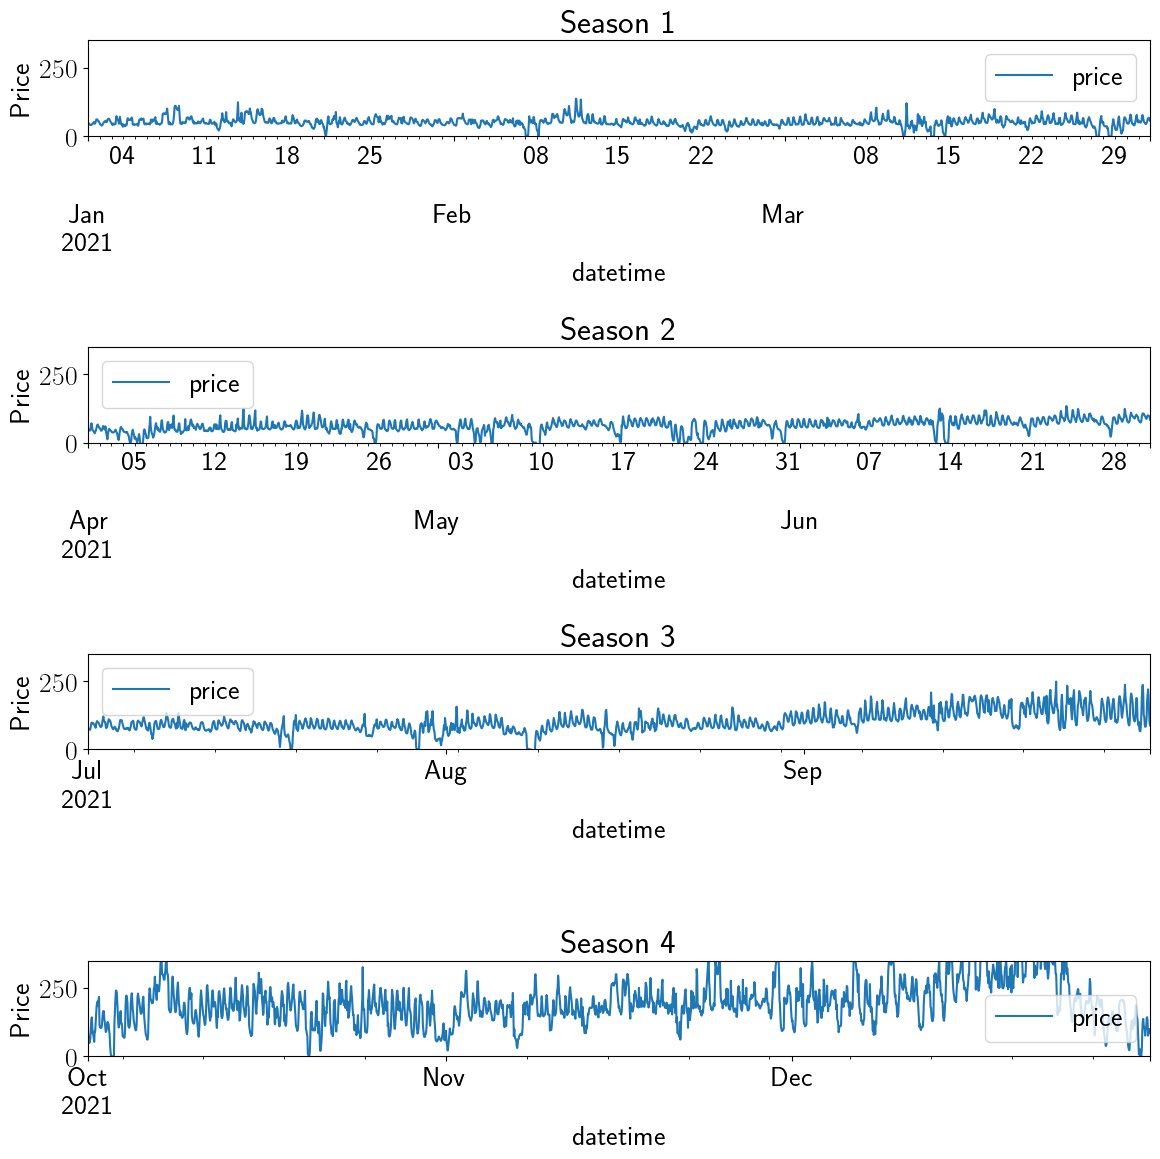

In [21]:
yearPlot = 2021
# yearPlot = 2019
maxPrice = 350

figsize = (12, 6)
priceClean.loc[priceClean['datetime'].dt.year == yearPlot].resample('D', on='datetime').mean().plot(y='price', figsize=figsize, ylim=(0, maxPrice), title=f'Average Daily Price in {yearPlot}', xlabel='Date', ylabel='Price (EUR/MWhe)')

figsize = (12, 12)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=figsize, sharey=True)
plt.subplots_adjust(hspace=0.2)
axes = axes.flatten()

for season in range(1, 5):
    seasonal_data = priceClean[(priceClean['datetime'].dt.month >= (season - 1) * 3 + 1) & 
                               (priceClean['datetime'].dt.month <= season * 3) & 
                               (priceClean['datetime'].dt.year == yearPlot)]
    ax = axes[season - 1]

    seasonal_data.plot(x='datetime', y='price', ax=ax)
    ax.set_ylim(0, maxPrice)
    ax.set_title(f'Season {season}')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

## Feature engineering

In [22]:
# yearTest = 2019
# maxPrice = 125
yearTest = 2021
maxPrice = 350
yearTrainStart = 2015

In [23]:
priceH = price.loc[(price['datetime'] >= pd.Timestamp('2015-01-05 00:00:00+01:00', tz='Europe/Amsterdam')) &
                   (price['datetime'].dt.year <= yearTest) & (price['datetime'].dt.year >= yearTrainStart), 
                   ['datetime', 'Price (EUR/MWhe)']].copy()
priceH.columns = ['datetime', 'price']

In [24]:
load_genH = load_gen.loc[(load_gen['datetime'] >= pd.Timestamp('2015-01-05 00:00:00+01:00', tz='Europe/Amsterdam'))& 
                         (load_gen['datetime'].dt.year <= yearTest) & (load_gen['datetime'].dt.year >= yearTrainStart)].copy()
load_genH.columns = ['datetime', 'load', 'res', 'nonres']

In [25]:
priceFinal = priceH.copy()
priceFinal.reset_index(drop=True, inplace=True)

In [26]:
priceFinal.loc[priceFinal['price'] < 0, 'price'] = 0 # ignore negative prices

In [27]:
# calendar features
priceFinal['monthOfYear'] = priceFinal['datetime'].dt.month
priceFinal['Hour'] = priceFinal['datetime'].dt.hour
priceFinal['dayOfWeek'] = priceFinal['datetime'].dt.dayofweek
priceFinal['weekOfYear'] = priceFinal['datetime'].dt.isocalendar().week
priceFinal['year'] = priceFinal['datetime'].dt.year

priceFinal = priceFinal.merge(load_genH, on='datetime', how='left')
priceFinal.drop(columns=['nonres'], inplace=True)


# weekly lag
# weekly_mean = priceFinal.groupby(['year', 'weekOfYear'])['price'].max().reset_index()
# weekly_mean.columns = ['year', 'weekOfYear', 'agg']
# lag_weekly_mean = weekly_mean.copy()
# lag_weekly_mean['isoWeek_max'] = weekly_mean['agg'].shift(1)
# lag_weekly_mean.drop(columns=['agg'], inplace=True)

# priceFinal = priceFinal.merge(lag_weekly_mean, on=['year', 'weekOfYear'], how='left')
priceFinal.drop(columns=['year', 'weekOfYear'], inplace=True)


# tso hourly forecast
priceFinal['date'] = priceFinal['datetime'].dt.date

da_load_max = priceFinal.groupby('date')['load'].max().reset_index()
da_load_max.columns = ['date', 'loadMax']
loadFinal = da_load_max

da_res_max = priceFinal.groupby('date')['res'].max().reset_index()
da_res_max.columns = ['date', 'resMax']
min_resMax = da_res_max.loc[da_res_max['resMax'] > 0, 'resMax'].min()
da_res_max.loc[da_res_max['resMax'] == 0, 'resMax'] = min_resMax
resFinal = da_res_max


# daily lag
# daily_sum = priceFinal.groupby('date')['price'].sum().reset_index()
# daily_sum.columns = ['date', 'sum']
# lag_daily_sum = daily_sum.copy()
# lag_daily_sum['isoDay_sum'] = daily_sum['sum'].shift(1)
# lag_daily_sum.drop(columns=['sum'], inplace=True)

daily_std = priceFinal.groupby('date')['price'].std().reset_index()
daily_std.columns = ['date', 'std']
lag_daily_std = daily_std.copy()
lag_daily_std['isoDay_std'] = daily_std['std'].shift(1)
lag_daily_std.drop(columns=['std'], inplace=True)

# daily_mean = priceFinal.groupby('date')['price'].mean().reset_index()
# daily_mean.columns = ['date', 'agg1']
# lag_daily_mean = daily_mean.copy()
# lag_daily_mean['isoDay_mean'] = daily_mean['agg1'].shift(1)
# lag_daily_mean.drop(columns=['agg1'], inplace=True)

# daily_max = priceFinal.groupby('date')['price'].max().reset_index()
# daily_max.columns = ['date', 'agg2']
# lag_daily_max = daily_max.copy()
# lag_daily_max['isoDay_max'] = daily_max['agg2'].shift(1)
# lag_daily_max.drop(columns=['agg2'], inplace=True)

# daily_min = priceFinal.groupby('date')['price'].min().reset_index()
# daily_min.columns = ['date', 'agg3']
# lag_daily_min = daily_min.copy()
# lag_daily_min['isoDay_min'] = daily_min['agg3'].shift(1)
# lag_daily_min.drop(columns=['agg3'], inplace=True)

priceFinal = priceFinal.merge(loadFinal, on='date', how='left')
priceFinal = priceFinal.merge(resFinal, on='date', how='left')
# priceFinal['normRes'] = (priceFinal['res']) / priceFinal['resMax']
# priceFinal['normLoad'] = (priceFinal['load']) / priceFinal['loadMax']
priceFinal['difRes'] = priceFinal['res'].diff(24) / priceFinal['resMax']
priceFinal['difLoad'] = priceFinal['load'].diff(24) / priceFinal['loadMax']

priceFinal.drop(columns=['res','resMax', 'load', 'loadMax'], inplace=True)

# priceFinal = priceFinal.merge(lag_daily_sum, on='date', how='left')
priceFinal = priceFinal.merge(lag_daily_std, on='date', how='left')
# priceFinal = priceFinal.merge(lag_daily_mean, on='date', how='left')
# priceFinal = priceFinal.merge(lag_daily_max, on='date', how='left')
# priceFinal = priceFinal.merge(lag_daily_min, on='date', how='left')

# priceFinal['isoDay_sum'] = priceFinal['isoDay_sum'] / priceFinal['isoWeek_max']
# priceFinal['isoDay_mean'] = priceFinal['isoDay_mean'] / priceFinal['isoWeek_max']
# priceFinal['isoDay_max'] = priceFinal['isoDay_max'] / priceFinal['isoWeek_max']
# priceFinal['isoDay_min'] = priceFinal['isoDay_min'] / priceFinal['isoWeek_max']

# priceFinal.drop(columns=['isoWeek_max'], inplace=True)

# output 
priceFinal['priceDif1'] = priceFinal['price'].diff(24)
priceFinal['priceRef'] = priceFinal['price'].shift(24)

priceFinal.drop(columns=['date'], inplace=True)

priceFinal.dropna(inplace=True)

In [28]:
priceFinal.head()

,datetime,price,monthOfYear,Hour,dayOfWeek,difRes,difLoad,isoDay_std,priceDif1,priceRef
24,2015-01-06 00:00:00+01:00,36.90,1,0,1,-0.021022,0.029394,7.785967,0.34,36.56
25,2015-01-06 01:00:00+01:00,35.04,1,1,1,-0.098901,0.022909,7.785967,0.10,34.94
26,2015-01-06 02:00:00+01:00,34.50,1,2,1,-0.184902,0.018334,7.785967,2.31,32.19
27,2015-01-06 03:00:00+01:00,33.47,1,3,1,-0.270425,0.014658,7.785967,5.42,28.05
28,2015-01-06 04:00:00+01:00,33.97,1,4,1,-0.291925,0.011723,7.785967,5.93,28.04


In [29]:
def season_datetimes(season, yearTest=2021, tz='America/Los_Angeles'):
    """
    Get all datetimes in the test set

    return datetimes_season: pd.DatetimeIndex with all datetimes in the test set
    """
    
    if season == 'winter':
        start_date = pd.Timestamp(year=yearTest, month=1, day=1, tz=tz)
        end_date = pd.Timestamp(year=yearTest, month=3, day=31, tz=tz) + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'spring':
        start_date = pd.Timestamp(year=yearTest, month=4, day=1, tz=tz)
        end_date = pd.Timestamp(year=yearTest, month=6, day=30, tz=tz) + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'summer':
        start_date = pd.Timestamp(year=yearTest, month=7, day=1, tz=tz)
        end_date = pd.Timestamp(year=yearTest, month=9, day=30, tz=tz) + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'autumn':
        start_date = pd.Timestamp(year=yearTest, month=10, day=1, tz=tz)
        end_date = pd.Timestamp(year=yearTest, month=12, day=31, tz=tz) + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    
    datetimes_season = pd.date_range(start=start_date, end=end_date, freq='15min')

    if season == 'winter':
        return datetimes_season[datetimes_season.date != (pd.to_datetime(f'{yearTest}-03-14').date())]
    if season == 'summer':
        return datetimes_season[(datetimes_season.date != (pd.to_datetime(f'{yearTest}-07-16').date())) & (datetimes_season.date != (pd.to_datetime(f'{yearTest}-07-17').date()))]
    if season == 'autumn':
        return datetimes_season[(datetimes_season.date != (pd.to_datetime(f'{yearTest}-11-07').date())) & (datetimes_season.date != (pd.to_datetime(f'{yearTest}-10-27').date()))]
    else:
        return datetimes_season

In [30]:
def filter_eval_datetime(n_days_eval_per_season, n_days_rolling_feature, yearTest=2019):
    eval_datetimes = pd.DatetimeIndex([])
    for s in ['winter', 'spring', 'summer', 'autumn']:
        s_dt = season_datetimes(s, yearTest=yearTest, tz='Europe/Amsterdam')
        eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season)])
    return eval_datetimes

In [31]:
test_datetimes = filter_eval_datetime(n_days_eval_per_season=70, n_days_rolling_feature=0, yearTest=yearTest)
# test_datetimes = filter_eval_datetime(n_days_eval_per_season=14, n_days_rolling_feature=0, yearTest=yearTest)

/var/folders/lb/mpk56nms22z5qxbrdw0jmd3h0000gn/T/ipykernel_13584/3490202729.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season)])


In [32]:
len(test_datetimes)

26880

In [33]:
# testPrice = priceFinal[(priceFinal['datetime'].dt.year == yearTest)]
testPrice = priceFinal[(priceFinal['datetime'].isin(test_datetimes))]
trainPrice = priceFinal[(priceFinal['datetime'].dt.year != yearTest)]

X_train = trainPrice.drop(columns=['datetime', 'price', 'priceDif1', 'priceRef'])
y_train = trainPrice[['datetime', 'priceDif1']]

X_test = testPrice.drop(columns=['datetime', 'price', 'priceDif1', 'priceRef']) 
y_test = testPrice[['datetime', 'priceDif1']]
y_testref = testPrice[['datetime', 'priceRef', 'price']]

In [34]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_testref.reset_index(drop=True, inplace=True)

In [35]:
X_test

,monthOfYear,Hour,dayOfWeek,difRes,difLoad,isoDay_std
0,1,0,4,-0.770665,0.002558,8.726082
1,1,1,4,-0.669368,0.006656,8.726082
2,1,2,4,-0.567801,0.002203,8.726082
3,1,3,4,-0.394381,-0.002527,8.726082
4,1,4,4,-0.289843,-0.010723,8.726082
...,...,...,...,...,...,...
6715,12,18,5,0.256490,-0.085120,48.178160
6716,12,19,5,0.201722,-0.074712,48.178160
6717,12,20,5,0.171665,-0.062815,48.178160
6718,12,21,5,0.155213,-0.049245,48.178160


## Train

In [ ]:
# mapie_enbpi = pickle.load(open(f'Models/Cda_MapieGBRv2_yearTest{yearTest}.pkl', 'rb'))

In [36]:
init_estimator = DummyRegressor(strategy='mean')
gbReg = GradientBoostingRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, validation_fraction=0.1, n_iter_no_change=15, loss='absolute_error', init=init_estimator, random_state=random_state)

In [37]:
cv_mapiets = BlockBootstrap(n_resamplings=15, length=24, overlapping=False, random_state=random_state)
mapie_enbpi = MapieTimeSeriesRegressor(gbReg, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1)
mapie_enbpi = mapie_enbpi.fit(X_train, y_train['priceDif1'])

/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/.venv/lib/python3.11/site-packages/mapie/utils.py:565: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/.venv/lib/python3.11/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


In [58]:
modelName = 'da_MapieGBRv2_yearTest' + str(yearTest)
print(modelName)

da_MapieGBRv2_yearTest2021


In [59]:
pickle.dump(mapie_enbpi, open(f'{modelFolder}/{modelName}.pkl', 'wb'))

## day-ahead preds

In [40]:
# alphas = [0.15, 0.25]
alphas = [0.1]

In [41]:
y_testref[y_testref.isna().any(axis=1)]

,datetime,priceRef,price


In [42]:
y_preds = np.zeros(len(X_test))
y_mapies = np.zeros((len(X_test), len(alphas), 2))

warnings.filterwarnings("ignore")
for a in range(len(alphas)):
    pred, ci = mapie_enbpi.predict(X_test, alpha=alphas[a], ensemble=False, allow_infinite_bounds=False, optimize_beta=False)
    y_preds = np.clip(pred[:] + y_testref['priceRef'], a_min=0, a_max=None)
    y_mapies[:, a, :] = np.clip(ci[:, :, 0]  + np.array([y_testref['priceRef'].values, y_testref['priceRef'].values]).T , a_min=0, a_max=None)

In [43]:
maxRangeAE = np.abs(y_testref['price'] - y_preds).max() - np.abs(y_testref['price'] - y_preds).min()
maxRangeAE

np.float64(196.67158899423976)

In [44]:
maxSeasons = {'Winter': 100, 'Spring': 110, 'Summer': 150, 'Autumn': 270, 'All': 300}
noTitlePlots = True 

In [45]:
def plot_daily_data_v2(filtered_y_test, filtered_y_pred, filtered_y_pi, season, start_days=0, length_days=30, showPlot=True):
    
    metricAE = np.abs(filtered_y_test['price'] - filtered_y_pred)
    metricBias = filtered_y_pred - filtered_y_test['price']
    print(f"MAE: {np.round(metricAE.mean(), 2)}. nMAE: {np.round(metricAE.mean()/maxRangeAE, 4)}. Avg bias: {np.round(metricBias.mean(), 2)}")

    if len(alphas) ==2:
        coverage_enbpi_npfit = regression_coverage_score(
            filtered_y_test['price'], filtered_y_pi[:, 1, 0], filtered_y_pi[:, 1, 1])
        width_enbpi_npfit = regression_mean_width_score(
            filtered_y_pi[:, 1, 0], filtered_y_pi[:, 1, 1])
    else:
        coverage_enbpi_npfit = regression_coverage_score(
            filtered_y_test['price'], filtered_y_pi[:, 0, 0], filtered_y_pi[:, 0, 1])
        width_enbpi_npfit = regression_mean_width_score(
            filtered_y_pi[:, 0, 0], filtered_y_pi[:, 0, 1])

    print(f'Coverage: {coverage_enbpi_npfit:.4f}. Width: {width_enbpi_npfit:.3f}')

    if start_days is not None:
        filtered_y_test = filtered_y_test.iloc[(start_days * 24):((start_days + length_days) * 24), :]
        filtered_y_pred = filtered_y_pred[(start_days * 24):((start_days + length_days) * 24)]
        filtered_y_pi = filtered_y_pi[(start_days * 24):((start_days + length_days) * 24)]
        filtered_AE = metricAE[(start_days * 24):((start_days + length_days) * 24)]

    if showPlot:
        fig, ax1 = plt.subplots(figsize=(8, 6))
        # fig, ax1 = plt.subplots(figsize=(12, 8))
        ax1.fill_between(filtered_y_test['datetime'], filtered_y_pi[:, 0, 0].flatten(), filtered_y_pi[:, 0, 1].flatten(), label=r'$\hat{p}_\mathrm{el}^{\mathrm{p}5-\mathrm{p}95}$', color='papayawhip')
        if len(alphas) ==2:
            ax1.fill_between(filtered_y_test['datetime'], filtered_y_pi[:, 1, 0].flatten(), filtered_y_pi[:, 1, 1].flatten(), label=r'$\hat{p}_\mathrm{el}^{\mathrm{p}25-\mathrm{p}75}$', color='papayawhip')
        ax1.plot(filtered_y_test['datetime'], filtered_y_test['price'], label=r'$p_\mathrm{el}$', color='tab:blue')
        ax1.plot(filtered_y_test['datetime'], filtered_y_pred, label=r'$\hat{p}_\mathrm{el}$', color='orange')
        # ax1.plot(filtered_y_test['datetime'], filtered_y_pi[:,0,1] - filtered_y_pi[:,0,0], label=r'width', color='red')
        ax1.bar(filtered_y_test['datetime'], filtered_AE, width=0.01, color='lightpink', label=r'$|p_\mathrm{el} - \hat{p}_\mathrm{el}|$')

        ax1.set_xlabel(r'$\mathrm{Date}$')
        ax1.set_ylabel(r'$\mathrm{Price \, [EUR/MWh]}$')
        ax1.legend(loc='upper center', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, fontsize=22)
        maxPrice = maxSeasons[season]
        ax1.set_ylim(0, maxPrice)
        # ax1.set_ylim(70, 300)
        ax1.set_xlim(filtered_y_test['datetime'].min(), filtered_y_test['datetime'].max())
        ax1.set_xticks(filtered_y_test['datetime'][24:-1:24*np.int64(1)]) #, rotation=45)  # Show every 96th datetime label
        # ax1.set_xticks(filtered_y_test['datetime'][24:-1:24*np.int64(length_days/4)]) #, rotation=45)  # Show every 96th datetime label
        ax1.grid()
        if not noTitlePlots:
            plt.title(rf'$\mathrm{{{season}-24h\,Ahead\,Prediction\,at\,H0\,}}\mathrm{{(1h\,res.)}}$')
        plt.tight_layout()
        plt.show()
        # fig.savefig(f'Figures/{modelName}_{season}_24Hahead.svg', format='svg', dpi=300, bbox_inches='tight')
        # fig.savefig(f'Figures/{modelName}_{season}_24Hahead.eps', format='eps', dpi=300, bbox_inches='tight')


    return metricAE, metricBias


In [46]:
Error, Bias = plot_daily_data_v2(y_testref, y_preds, y_mapies, 'All', length_days=280, showPlot=False)

MAE: 19.33. nMAE: 0.0983. Avg bias: -3.49
Coverage: 0.6004. Width: 25.199


MAE: 7.6. nMAE: 0.0386. Avg bias: -0.18
Coverage: 0.8280. Width: 25.293


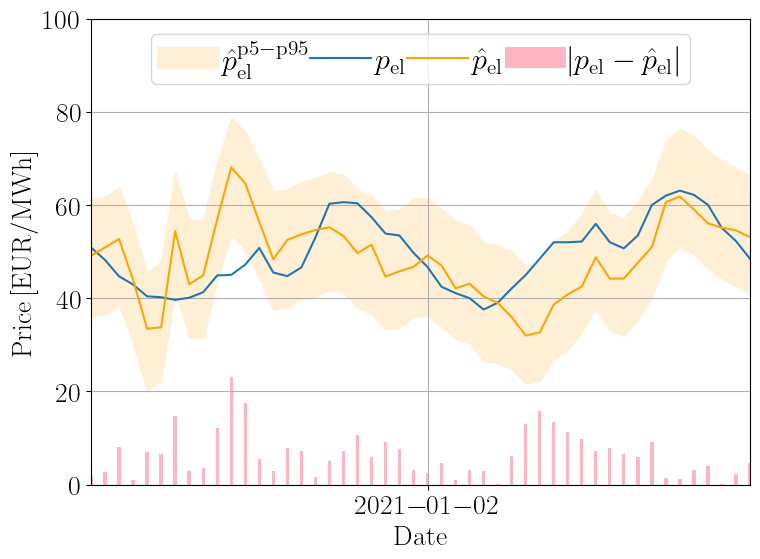

MAE: 11.57. nMAE: 0.0588. Avg bias: -0.94
Coverage: 0.6899. Width: 24.974


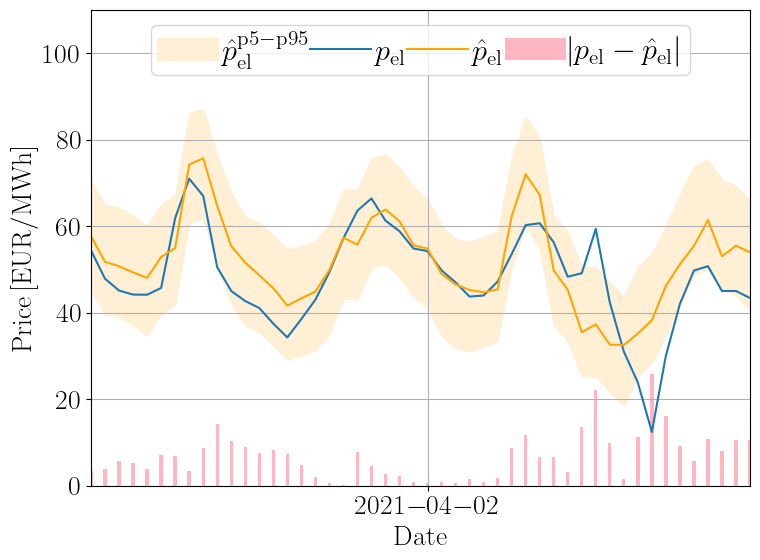

MAE: 13.23. nMAE: 0.0673. Avg bias: -1.65
Coverage: 0.6625. Width: 25.269


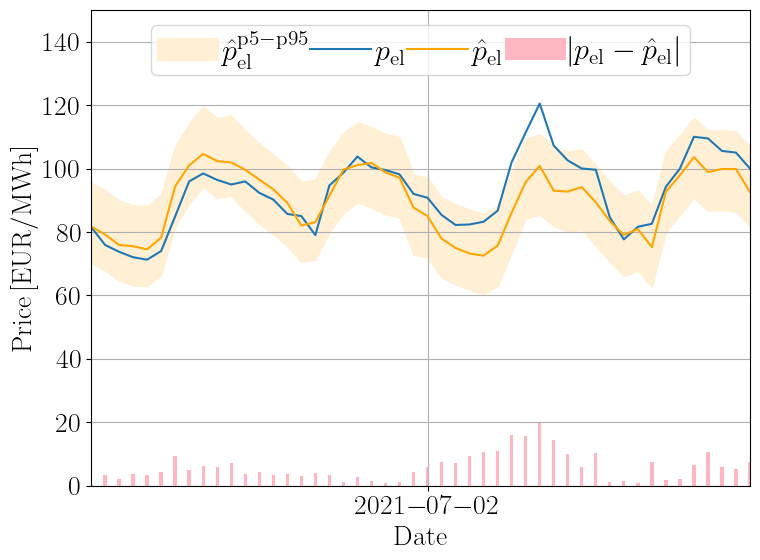

MAE: 44.93. nMAE: 0.2284. Avg bias: -11.18
Coverage: 0.2214. Width: 25.262


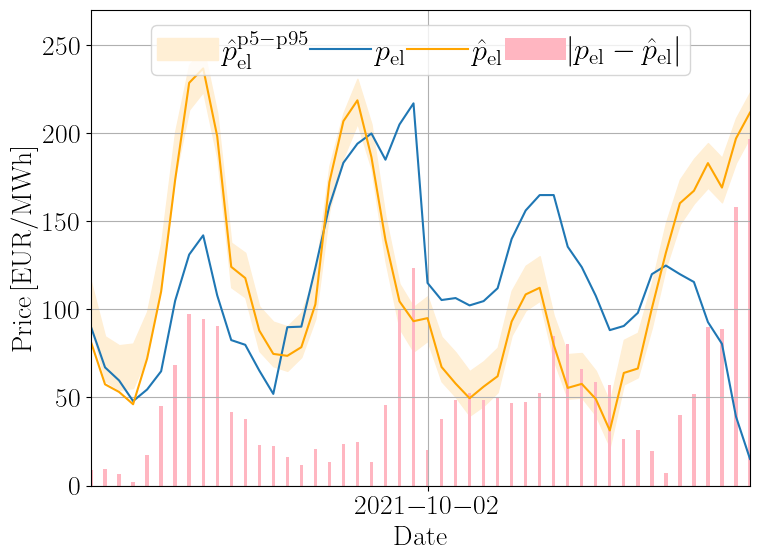

In [47]:
test_datetimes_winter = s_dt = season_datetimes('winter', yearTest=yearTest, tz='Europe/Amsterdam')
test_datetimes_spring = s_dt = season_datetimes('spring', yearTest=yearTest, tz='Europe/Amsterdam')
test_datetimes_summer = s_dt = season_datetimes('summer', yearTest=yearTest, tz='Europe/Amsterdam')
test_datetimes_autumn = s_dt = season_datetimes('autumn', yearTest=yearTest, tz='Europe/Amsterdam')

filtered_y_test_winter = y_testref[y_testref['datetime'].isin(test_datetimes_winter)]
filtered_y_test_winter_idx = y_testref[y_testref['datetime'].isin(test_datetimes_winter)].index
filtered_y_preds_winter = y_preds[filtered_y_test_winter_idx]
filtered_y_pis_winter = y_mapies[filtered_y_test_winter_idx]

filtered_y_test_spring = y_testref[y_testref['datetime'].isin(test_datetimes_spring)]
filtered_y_test_spring_idx = y_testref[y_testref['datetime'].isin(test_datetimes_spring)].index
filtered_y_preds_spring = y_preds[filtered_y_test_spring_idx]
filtered_y_pis_spring = y_mapies[filtered_y_test_spring_idx]

filtered_y_test_summer = y_testref[y_testref['datetime'].isin(test_datetimes_summer)]
filtered_y_test_summer_idx = y_testref[y_testref['datetime'].isin(test_datetimes_summer)].index
filtered_y_preds_summer = y_preds[filtered_y_test_summer_idx]
filtered_y_pis_summer = y_mapies[filtered_y_test_summer_idx]

filtered_y_test_autumn = y_testref[y_testref['datetime'].isin(test_datetimes_autumn)]
filtered_y_test_autumn_idx = y_testref[y_testref['datetime'].isin(test_datetimes_autumn)].index
filtered_y_preds_autumn = y_preds[filtered_y_test_autumn_idx]
filtered_y_pis_autumn = y_mapies[filtered_y_test_autumn_idx]

plot_n_days = 2
wntError, wntBias = plot_daily_data_v2(filtered_y_test_winter, filtered_y_preds_winter, filtered_y_pis_winter, 'Winter', length_days=plot_n_days, showPlot=True)
sprError, sprBias = plot_daily_data_v2(filtered_y_test_spring, filtered_y_preds_spring, filtered_y_pis_spring, 'Spring', length_days=plot_n_days, showPlot=True)
smrError, smrBias = plot_daily_data_v2(filtered_y_test_summer, filtered_y_preds_summer, filtered_y_pis_summer, 'Summer', length_days=plot_n_days, showPlot=True)
atmError, atmBias = plot_daily_data_v2(filtered_y_test_autumn, filtered_y_preds_autumn, filtered_y_pis_autumn, 'Autumn', length_days=plot_n_days, showPlot=True)

In [48]:
mean_errors = np.array([wntError.mean()/maxRangeAE, sprError.mean()/maxRangeAE, smrError.mean()/maxRangeAE, atmError.mean()/maxRangeAE])
mean_bias = np.array([wntBias.mean(), sprBias.mean(), smrBias.mean(), atmBias.mean()])
# mean_width = np.array([wntWidth, sprWidth, smrWidth, atmWidth])
# median_errors = np.array([wntError.median(), sprError.median(), smrError.median(), atmError.median()])

rounded_mean_errors = [round(err, 4) for err in mean_errors]
rounded_mean_bias = [round(b, 2) for b in mean_bias]
# rounded_mean_width = [round(b, 4) for b in mean_width]
# rounded_median_errors = [round(err, 2) for err in median_errors]

pd.DataFrame({'Season': ['Winter', 'Spring', 'Summer', 'Autumn'], 'MAE': rounded_mean_errors, 'Bias': rounded_mean_bias})
            #   'Width': rounded_mean_width})

,Season,MAE,Bias
0,Winter,0.0386,-0.18
1,Spring,0.0588,-0.94
2,Summer,0.0673,-1.65
3,Autumn,0.2284,-11.18


In [81]:
# plot_n_days = 30
# for i in range(12):
#     Error, Bias = plot_daily_data_v2(y_testref, y_preds, y_mapies, 'All', start_days=i*31 + 1, length_days=plot_n_days, showPlot=True)

## Energy Hub

### save eval info

In [49]:
save_datetimes = filter_eval_datetime(n_days_eval_per_season=88, n_days_rolling_feature=0, yearTest=yearTest)

In [50]:
save_datetimes

DatetimeIndex(['2021-01-01 00:00:00+01:00', '2021-01-01 00:15:00+01:00',
               '2021-01-01 00:30:00+01:00', '2021-01-01 00:45:00+01:00',
               '2021-01-01 01:00:00+01:00', '2021-01-01 01:15:00+01:00',
               '2021-01-01 01:30:00+01:00', '2021-01-01 01:45:00+01:00',
               '2021-01-01 02:00:00+01:00', '2021-01-01 02:15:00+01:00',
               ...
               '2021-12-29 20:30:00+01:00', '2021-12-29 20:45:00+01:00',
               '2021-12-29 21:00:00+01:00', '2021-12-29 21:15:00+01:00',
               '2021-12-29 21:30:00+01:00', '2021-12-29 21:45:00+01:00',
               '2021-12-29 22:00:00+01:00', '2021-12-29 22:15:00+01:00',
               '2021-12-29 22:30:00+01:00', '2021-12-29 22:45:00+01:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', length=33792, freq=None)

In [51]:
len(save_datetimes)

33792

In [52]:
saveEval = testPrice.loc[testPrice['datetime'].isin(save_datetimes), :].reset_index(drop=True)

In [53]:
saveEval.reset_index(drop=True, inplace=True)

In [54]:
saveEval

,datetime,price,monthOfYear,Hour,dayOfWeek,difRes,difLoad,isoDay_std,priceDif1,priceRef
0,2021-01-01 00:00:00+01:00,50.87,1,0,4,-0.770665,0.002558,8.726082,6.27,44.60
1,2021-01-01 01:00:00+01:00,48.19,1,1,4,-0.669368,0.006656,8.726082,4.09,44.10
2,2021-01-01 02:00:00+01:00,44.68,1,2,4,-0.567801,0.002203,8.726082,-2.32,47.00
3,2021-01-01 03:00:00+01:00,42.92,1,3,4,-0.394381,-0.002527,8.726082,0.95,41.97
4,2021-01-01 04:00:00+01:00,40.39,1,4,4,-0.289843,-0.010723,8.726082,8.72,31.67
...,...,...,...,...,...,...,...,...,...,...
6715,2021-12-11 18:00:00+01:00,274.19,12,18,5,0.256490,-0.085120,48.178160,-18.79,292.98
6716,2021-12-11 19:00:00+01:00,222.50,12,19,5,0.201722,-0.074712,48.178160,-27.78,250.28
6717,2021-12-11 20:00:00+01:00,218.80,12,20,5,0.171665,-0.062815,48.178160,-31.20,250.00
6718,2021-12-11 21:00:00+01:00,193.61,12,21,5,0.155213,-0.049245,48.178160,-35.31,228.92


In [56]:
fileName = f'AllTest_da_{yearTest}_v0'
print(fileName)

AllTest_da_2021_v0


In [57]:
saveEval.to_csv(f'EnergyHubEval/{fileName}.csv', index=False)